# Linear models with Scikit-learn

In [55]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from matplotlib import colors 
import colour

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Boston

In [2]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_test, y_test) # bounces around depending on test set

0.7708755228175374

In [5]:
x = [[0.03, 0, 7, 0, 0.47, 7.2, 61.1, 4.97, 2, 242, 17.8, 392, 4]]
lm.predict(x)

array([30.26195499])

In [6]:
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(lm.score(X_test, y_test))

0.7388376715660869
0.6970674310956291
0.642637226412089
0.6177880146548231
0.7068441337455823


In [7]:
# RF has more stable scores and generally better but linear model works well here
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train, y_train)
    print(rf.score(X_test, y_test))

0.834390109887832
0.8331818003350802
0.8645370775581069
0.8039080326275352
0.8588753986262514


## NYC rent data set (Kaggle)

*Data use rules prevent us from storing this data in this repo*. Download the data
set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
and save `train.json` as `rent-train.json`.

In [8]:
def load_rent():
    df = pd.read_json('../../data/rent-train.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [9]:
df_rent = load_rent()
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
111817,1,1.0,40.7302,-73.9924
117995,0,1.0,40.7576,-73.9677
114617,3,2.0,40.7388,-73.9851
117474,1,1.0,40.7939,-73.9738
103891,1,1.0,40.7784,-73.9491


In [10]:
def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    print(f"{n} trials; training {np.mean(train_scores):.3f}, testing {np.mean(test_scores):.3f}")
    if hasattr(model,'coef_'):
        print(f"Coeff {[round(c,2) for c in model.coef_]}")

In [11]:
score(X, y, LinearRegression())

10 trials; training 0.579, testing 0.577
Coeff [441.59, 1488.03, 1235.29, -15634.68]


### Random Forest much stronger than linear model

In [12]:
score(X, y, RandomForestRegressor(n_estimators=10), n=5)

5 trials; training 0.943, testing 0.855


## Adding codependent and noise columns likely doesn't affect predictions

sklearn and other packages remove the codependent features before solving for beta coefficients. Hmm...I thought so but sklearn seems to share coeff values for dup columns and doesn't drop them.  Accuracy is same for this data set anyway, but betas are different.

In [13]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [14]:
score(X, y, LinearRegression(), n=30)

30 trials; training 0.743, testing 0.712
Coeff [-0.12, 0.04, 0.04, 1.06, -17.51, 3.85, 0.01, -1.31, 0.28, -0.01, -1.07, 0.01, -0.52]


In [15]:
score(X, y, Lasso(normalize=True, alpha=.001, max_iter=10_000), n=30)

30 trials; training 0.738, testing 0.734
Coeff [-0.11, 0.06, -0.03, 2.18, -14.96, 3.21, 0.0, -1.63, 0.31, -0.01, -0.84, 0.01, -0.54]


In [16]:
# Add noise columns
for i in range(3):
    X[f'noise{i}'] = np.random.random_sample(len(X))*5
# dup some columns
X['CRIM2'] = X['CRIM']
X['AGE2'] = X['AGE']
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,noise0,noise1,noise2,CRIM2,AGE2
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,3.310672,2.571950,3.276393,0.00632,65.2
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0.246382,3.774184,4.802859,0.02731,78.9
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,1.878272,0.552992,4.336088,0.02729,61.1
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,3.998550,1.027744,0.233535,0.03237,45.8
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,3.327191,2.123977,0.451044,0.06905,54.2


In [17]:
score(X, y, LinearRegression(), n=30)

30 trials; training 0.745, testing 0.703
Coeff [-0.06, 0.04, 0.04, 2.91, -19.85, 4.22, 0.0, -1.42, 0.32, -0.01, -1.03, 0.01, -0.49, -0.07, -0.16, 0.15, -0.06, 0.0]


In [18]:
score(X, y, Lasso(normalize=True, alpha=.0001, max_iter=10_000), n=30)

30 trials; training 0.743, testing 0.714
Coeff [-0.12, 0.03, -0.01, 3.48, -14.49, 4.36, -0.02, -1.5, 0.28, -0.01, -0.88, 0.01, -0.45, -0.05, -0.23, 0.06, -0.0, -0.0]


## Plot residuals

Example: consumption of monthly food budget. When do we run out of pizza money?

In [19]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(1,n,num=n)
df['y'] = [500, 490, 487, 451, 434, 418, 401, 390, 376, 350]
df['y'] = df.y - df.x *2.5 - np.random.uniform(0,50,size=n)

(0.0, 500.0)

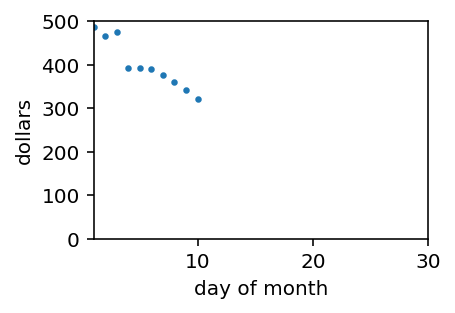

In [20]:
plt.figure(figsize=(3,2))
plt.scatter(df.x, df.y, s=5)
plt.xlabel('day of month')
plt.ylabel('dollars')
plt.xlim(1,30)
plt.ylim(0,500)

In [21]:
def mse(y,y_pred):
    return np.mean( (y - y_pred)**2 )

def line_fit(B, x):
    return B[2-1]*x + B[1-1]

def plot_residuals(x,y,B,xlabel,ylabel,line_xrange=None):
    fig, ax = plt.subplots(figsize=(4,2.5))
    ly = line_fit(B,x)
    ax.scatter(x, y, linewidth=.5, s=15)
    for c,d in zip(x,y):
        plt.plot([c,c],[line_fit(B,c),d], color='red', linewidth=.5)
    if line_xrange is not None:
        lx = np.arange(*line_xrange)
        gline, = plt.plot(lx,line_fit(B,lx),'--',color='grey', linewidth=1)
    else:
        gline, = plt.plot(x,ly,'--',color='grey', linewidth=1)
    loss = mse(ly, y)
    ax.text(17,350, f"Loss is {loss:.2f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right',
            handles=[gline],
           labels=[f"Equation is $y = {B[0]:.1f} + {B[1]:.1f}x$"],
            fontsize=10)

(0.0, 500.0)

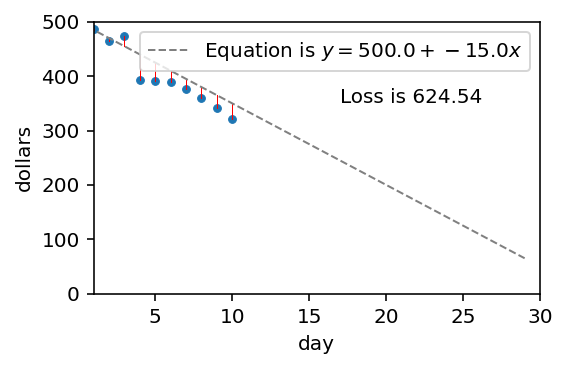

In [22]:
plot_residuals(df.x, df.y, [500,-15], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0.0, 500.0)

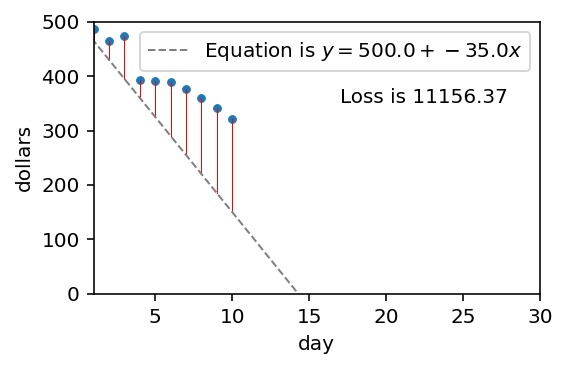

In [23]:
plot_residuals(df.x, df.y, [500,-35], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

(0.0, 500.0)

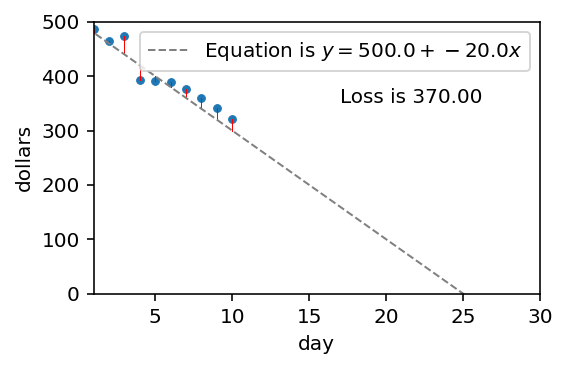

In [24]:
plot_residuals(df.x, df.y, [500,-20], xlabel='day', ylabel='dollars', line_xrange=(0,30))
plt.xlim(1,30)
plt.ylim(0,500)

## 2D Wine logistic viz

In [92]:
def wine_show(df, features=['proline','alcohol'], normalize=False, file=None):
    if normalize:
        df = df.copy()
        df.proline = (df.proline-np.mean(df.proline))/np.std(df.proline)
        df.alcohol = (df.alcohol-np.mean(df.alcohol))/np.std(df.alcohol)
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['y']==0]
    df1 = df[df['y']==1]
    ax.scatter(df0[features[0]], df0[features[1]], marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1[features[0]], df1[features[1]], marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    plt.show()
    
def wine_decision_show(model, df, features=['proline','alcohol'], 
                       boundary_tolerance=.01, file=None):
    X = df_wine[features].values
    y = df_wine['y'].values
    grid = []
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = np.array(grid)
    proba = model.predict_proba(grid)[:,1]
    decisions = model.predict(grid)

    grid_boundary = grid[np.isclose(proba,0.5,atol=boundary_tolerance),:]

    fig, ax = plt.subplots(figsize=(5,4))
    X0 = X[y==0]
    X1 = X[y==1]

    orange = colour.Color("#F46C43")
    blue = colour.Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(decisions*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(decisions), np.max(decisions)) # cmap(norm(decisions))
    ax.scatter(grid[:,0], grid[:,1], s=.2, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)

    ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, lw=.9, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, lw=.9, color='#4574B4', alpha=.75, label='class 1')    

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.tight_layout()

In [98]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}
X = df_wine.drop('y', axis=1)

# Just 2 features
features = ['alcohol', 'total_phenols']
X = X[features]
y = df_wine['y']

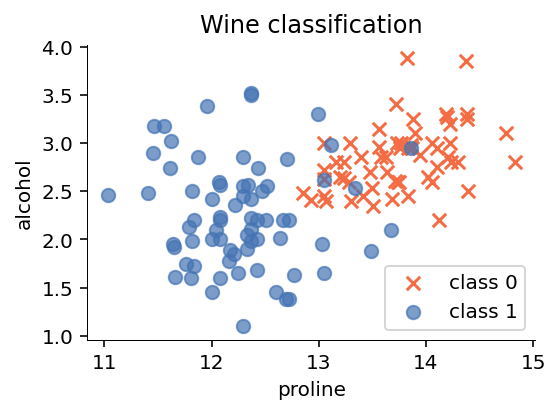

In [99]:
wine_show(df_wine, features=['alcohol','total_phenols'])

coefficients [43.21422647 -3.07478185 -1.18771919]


Text(0.5, 1.0, '2D wine data set, $P(y=1|x)$')

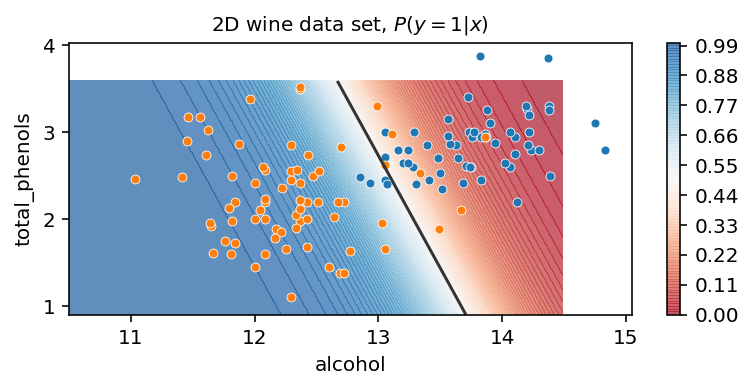

In [100]:
lm = LogisticRegression(solver='lbfgs')
lm.fit(X,y)
b = np.array([lm.intercept_[0],*lm.coef_[0]]).flatten()
print("coefficients", b)
xx,yy = np.mgrid[10.5:14.5:.01, .9:3.6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = lm.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(6.3,2.5))
contour = ax.contourf(xx, yy, probs, 100, cmap="RdBu",
                      vmin=-.1, vmax=1.1,
                      alpha=.7)
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6) # black line
ax_c = f.colorbar(contour)

plt.scatter(X_1.iloc[:,0], X_1.iloc[:,1], s=20, label='class1', edgecolor="white", lw=.4)
plt.scatter(X_2.iloc[:,0], X_2.iloc[:,1], s=20, label='class2', edgecolor="white", lw=.4)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("2D wine data set, $P(y=1|x)$", fontsize=10)

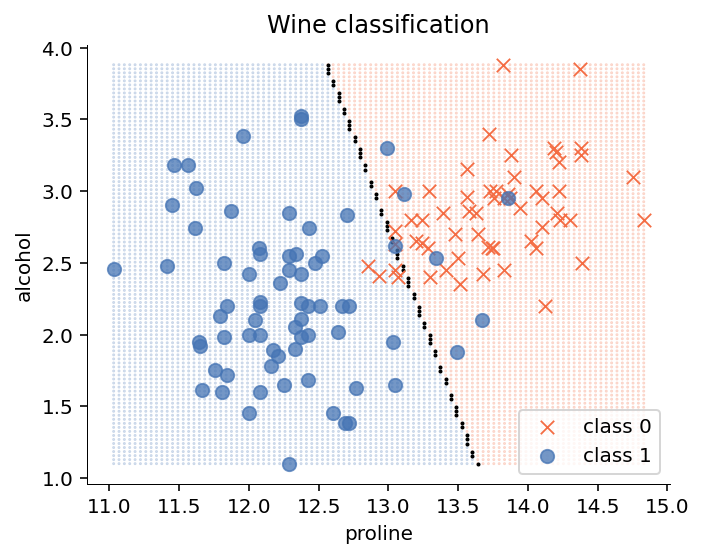

In [103]:
wine_decision_show(model, df_wine, features=['alcohol','total_phenols'])

### 1D alcohol vs class 1,2

In [27]:
def plot12(X,y):
    X_1 = X[y==0]
    X_2 = X[y==1]

    plt.figure(figsize=(4.8,1.3))
    plt.scatter(X_1, [0]*len(X_1), s=20, alpha=.8, label='class1')
    plt.scatter(X_2, [1]*len(X_2), s=20, alpha=.8, label='class2')
    plt.xlabel('alcohol')
    plt.ylabel('class')
    plt.legend(loc='upper left', fontsize=9)
    plt.title("1D wine data set, classes 1,2", fontsize=10)

([<matplotlib.axis.YTick at 0x7fe2a2802ca0>,
 [Text(0, 0, ''), Text(0, 0, '')])

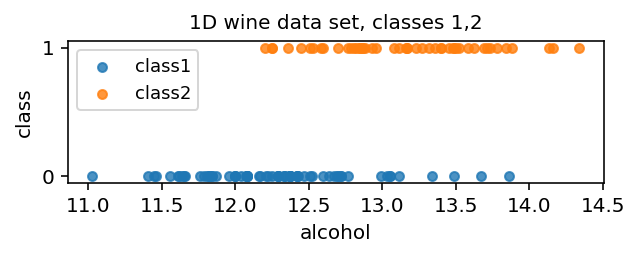

In [28]:
X = df_wine.drop('y', axis=1)
X = X['alcohol']
y = df_wine['y']
plot12(X,y)
plt.yticks([0,1])

Text(0.5, 1.0, 'Linear model prediction of int target $y$\n(Classes {1,2} renamed {0,1} to fit model)')

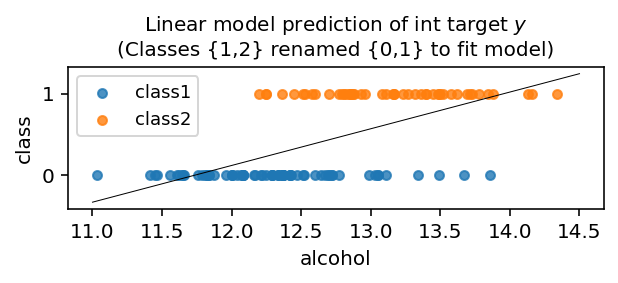

In [29]:
X_ = X.values.reshape(-1,1)
lm = LinearRegression()
lm.fit(X_, y)
plot12(X,y)
#print(lm.coef_, lm.intercept_)
lx = np.linspace(11,14.5).reshape(-1,1)
plt.plot(lx, lm.predict(lx), lw=.5, c='k')
plt.title("Linear model prediction of int target $y$\n(Classes {1,2} renamed {0,1} to fit model)",
         fontsize=10)

In [30]:
X_ = X.values.reshape(-1,1)
lm = LogisticRegression(solver='lbfgs')
lm.fit(X_,y)
b = np.array([lm.intercept_,lm.coef_]).flatten().astype(float)
print("coefficients", b)

coefficients [-30.06488497   2.33813334]


<ipython-input-30-bca0e8eeca42>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  b = np.array([lm.intercept_,lm.coef_]).flatten().astype(float)


Text(0.5, 1.0, 'Logistic model prediction of int target $y$\n(Classes {1,2} renamed {0,1} to fit model)')

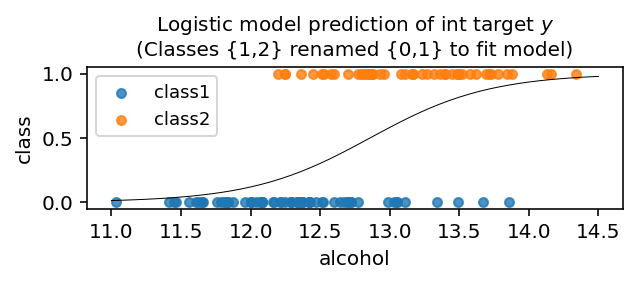

In [31]:
plot12(X,y)
lx = np.linspace(11,14.5).reshape(-1,1)
plt.plot(lx, lm.predict_proba(lx)[:,1], lw=.5, c='k')
plt.title("Logistic model prediction of int target $y$\n(Classes {1,2} renamed {0,1} to fit model)",
         fontsize=10)

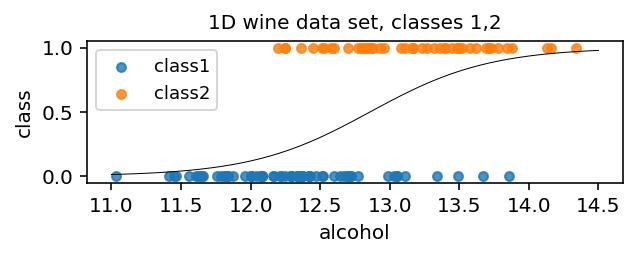

In [32]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

plot12(X,y)

B0 = np.ones(shape=(len(lx), 1))
X1 = np.hstack([B0, lx]).astype(float)

y_pred = np.dot(X1,b)

plt.plot(lx, sigmoid(y_pred), lw=.5, c='k')